In [ ]:
import polars as pl     # requires installing polars first
import pyarrow          # requires installing pyarrow first

In [1]:
import pandas as pd 

from tqdm import tqdm

ERROR: unknown command "import"


In [1]:
# Data packages
#import polars as pl     # requires installing polars first
#import pyarrow          # requires installing pyarrow first

import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

from model.rnn import GRUDecoder
from model.autoencoder import AutoEncoder
from data_processing.pipeline import encoding_pipeline

In [2]:
def get_device():
    # Check if CUDA is available
    if torch.cuda.is_available():
        # If CUDA is available, select the first CUDA device
        device = torch.device("cuda:0")
        print("Using CUDA device:", torch.cuda.get_device_name(0))
    # Check for MPS availability on supported macOS devices (requires PyTorch 1.12 or newer)
    elif torch.backends.mps.is_available():
        # If MPS is available, use MPS device
        device = torch.device("mps")
        print("Using MPS (Metal Performance Shaders) device")
    else:
        # Fallback to CPU if neither CUDA nor MPS is available
        device = torch.device("cpu")
        print("Using CPU")
    return device
device = get_device()

Using MPS (Metal Performance Shaders) device


# Read the data

Right now the notebook is set to work with fake data. This can be changed once the pipeline works.

The data is stored as a Dict[person_id, Sequences] where Sequences is a Dict[year, survery_wave_response]

In [3]:
import os
path = os.getcwd()

In [4]:
# read in data and prepare transformations
data = pd.read_csv(path + "/data/training/PreFer_train_data.csv", nrows=100)#,
                     #infer_schema_length=7418).to_pandas()
targets = pd.read_csv('data/training/PreFer_train_outcome.csv')
codebook = pd.read_csv('data/codebooks/PreFer_codebook.csv')

/var/folders/y6/j9fbqcvx6lb5l99614n30y4c0000gn/T/ipykernel_5096/2484417188.py:2: DtypeWarning: Columns (2583,2584,2585,2586,2587,2588,5215,6622,6635,6648,6661,6965,6966,6967,6968,6969,6971,6972,6973,6974,7064,7065,7071,7072,7164,7170,7408,7410,7412,7413,8818,8819,8821,8822,8823,8825,9989,9990,9991,9992,9993,9994,9995,9997,9998,10736,10737,10738,10740,10741,10742,10743,10744,10745,10746,10747,10748,11897,11901,11902,12168,12169,12170,12172,12173,12174,12181,12182,13339,13340,13341,13342,13343,13344,13345,13346,13347,13348,13349,15951,15952,16607,16612,16754,16755,16756,16761,17644,17645,17646,17647,17810,17914,18055,18056,18057,18058,18059,18060,18061,18062,18063,18064,18065,18066,18067,18068,18070,18071,18072,18073,18074,18075,18076,18077,18078,18079,18080,18081,18082,18083,18085,18086,18087,18088,18089,18090,18091,18092,18093,18094,18095,18096,18097,18098,18099,18100,18101,18102,18103,18104,18105,18106,18107,18108,18109,18110,18208,18209,18210,18211,18212,18213,18215,18216,18217,18218

In [14]:
import data_processing.pipeline
import data_processing.sequences
import data_processing.encoding.categorical
import importlib

importlib.reload(data_processing.pipeline)# import encoding_pipeline
importlib.reload(data_processing.sequences)
importlib.reload(data_processing.encoding.categorical)

from data_processing.pipeline import encoding_pipeline

In [17]:
from data_processing.encoding.categorical import CategoricalTransformer

In [37]:
categorical_columns = codebook[codebook.type_var == 'categorical'].var_name

In [36]:
test_data = data[categorical_columns]

KeyError: "['positie', 'lftdcat', 'aantalhh', 'aantalki', 'partner', 'burgstat', 'woonvorm', 'woning', 'belbezig', 'brutocat', 'nettocat', 'oplzon', 'oplmet', 'oplcat', 'doetmee', 'sted', 'simpc', 'werving', 'gender_imp', 'migration_background_imp'] not in index"

In [38]:
test = CategoricalTransformer()
test.fit(codebook=None, use_codebook=False)
test.transform(test_data)

values_cat    object
labels_cat    object
var_name      object
dtype: object


,cf08a001,cf09b001,cf10c001,cf11d001,cf12e001,cf13f001,cf14g001,cf15h001,cf16i001,cf17j001
0,101,101,101,101,101,101,101,101,101,101
1,101,101,101,101,101,101,101,101,101,101
2,101,101,101,101,101,101,101,101,101,101
3,101,101,101,101,101,101,101,101,101,101
4,101,101,101,101,101,101,101,101,101,101
...,...,...,...,...,...,...,...,...,...,...
95,101,101,101,101,101,101,101,101,101,101
96,101,101,101,101,101,101,101,101,101,101
97,101,101,101,101,101,101,101,101,101,101
98,101,101,101,101,101,101,101,101,101,101


In [15]:
sequences = encoding_pipeline(data, codebook, use_codebook=True)

var_name            object
var_label           object
values_cat          object
labels_cat          object
unique_values_n    float64
n_missing            int64
prop_missing       float64
type_var            object
note                object
year               float64
survey              object
dataset             object
dtype: object


KeyboardInterrupt: 

In [29]:
sequences = encoding_pipeline(data, codebook, use_codebook=False)

values_cat    object
labels_cat    object
var_name      object
dtype: object


KeyError: 'nomem_encr'

In [66]:
import ast

fun = lambda x: ast.literal_eval(x)

test = pd.Series([ 
    "['chicken', 'child 4']",
    "['child 1', 'child 2', 'child 3', 'Somthing']",
    "['child 1', 'child 2', 'child 3']",
    "['child 1', 'child 2', 'child 3', 'child 4']" 
])

test.apply(ast.literal_eval)
#fun = lambda x: [int(num) for num in ast.literal_eval(x)]

#test2 = test.apply(fun)

0                       [chicken, child 4]
1    [child 1, child 2, child 3, Somthing]
2              [child 1, child 2, child 3]
3     [child 1, child 2, child 3, child 4]
dtype: object

# Train the autoencoder

In [28]:
from model.dataset import PretrainingDataset
pretrain_dataset = PretrainingDataset(sequences)

In [29]:
### Initialization of the Autoencoder 
HIDDEN_DIM = 256
ENCODING_SIZE = 64
BATCH_SIZE = 16
num_epochs_autoencoder = 5
learning_rate_autoencoder = 5e-4

SEQ_LEN = pretrain_dataset.get_seq_len()
vocab_size = pretrain_dataset.get_vocab_size()

train_dataloader = DataLoader(pretrain_dataset, batch_size=BATCH_SIZE, shuffle=True)
autoencoder = AutoEncoder(vocab_size=vocab_size, embedding_size=HIDDEN_DIM, encoding_size=ENCODING_SIZE, sequence_len=SEQ_LEN).to(device)

loss_f1 = nn.HuberLoss(delta=1.0)
loss_cls = nn.CrossEntropyLoss(label_smoothing=0.1)
loss_cos = nn.CosineEmbeddingLoss()
optimizer = optim.RAdam( autoencoder.parameters(), lr = learning_rate_autoencoder, weight_decay=1e-2, decoupled_weight_decay=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = num_epochs_autoencoder, eta_min = 1e-5, last_epoch = -1)

/opt/anaconda3/envs/PreFer/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### (either) Load the pre-trained Autoencoder

In [13]:
### INSTEAD YOU CAN SALDO LOAD A MODEL
try:
    model_path = "weights/autoencoder_10_05.pt"
    autoencoder = AutoEncoder(vocab_size=vocab_size, embedding_size=HIDDEN_DIM, encoding_size=ENCODING_SIZE, sequence_len=SEQ_LEN)
    autoencoder.load_state_dict(torch.load(model_path, map_location=device))
except:
    print("Model is not found")


Model is not found


/Users/carlomarx/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### (or) Train the autoencoder

In [30]:
autoencoder.train()
# device = torch.device("cpu") # mps is not working for Me (Mikkel)
autoencoder.to(device)
loss_metric = []
for epoch in range(num_epochs_autoencoder):
    loss_epoch_metric = []
    loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
    for i, (year, seq) in loop_object :
        optimizer.zero_grad()
        year = year.to(device)
        seq = seq.to(device)

        x1, x2 = autoencoder(year, seq)
        loss = loss_cls(x2.permute(0,2,1), seq.long()) + loss_cos(x1.reshape(x1.size(1) * x1.size(0), -1 ), 
                                                                autoencoder.embedding(year, seq).view(x1.size(1) * x1.size(0), -1), 
                                                                torch.ones(seq.size(0) * seq.size(1)).to(device))
         #+ 0.7 * loss_f1(x1, autoencoder.embedding(year, seq)) +  
        loss_epoch_metric.append(loss.detach().cpu().numpy())
        loss.backward()
        optimizer.step()
        loop_object.set_postfix_str("mean loss: %.3f"%np.mean(loss_epoch_metric[-100:]))
    ## After epoch end
    scheduler.step()
    loss_metric.append(np.mean(loss_epoch_metric))
    print(f'epoch {epoch} \t Loss: {loss_metric[-1]:.4g} and LR: {scheduler.get_last_lr()[0]:.5g}')

Epochs 0: 5616it [1:40:21,  1.07s/it, mean loss: 1.263]


epoch 0 	 Loss: 1.505 and LR: 0.00045321


Epochs 1: 3629it [51:51,  1.17it/s, mean loss: 1.236]


KeyboardInterrupt: 

#### Save the weights of the pretrained autoencoder

In [34]:
len(pretrain_dataset)

420

### Explroe the embedding space

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


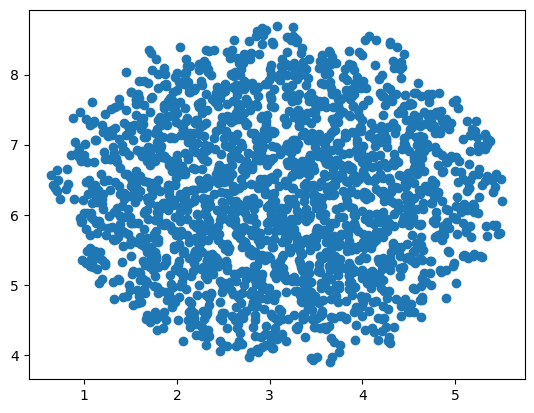

In [9]:
import umap
import matplotlib.pyplot as plt
w = autoencoder.embedding.answer_embedding.weight.detach().cpu().numpy()
projector = umap.UMAP(n_components=2)
wp = projector.fit_transform(w)
plt.scatter(wp[:,0], wp[:,1])


# Train the RNN

First we need to create Dataset class that can hold both the target (stored in a pd.DataFrame) and the sequences.

The sequences will be of dimension 14 x encoding_dimension, because we have 14 years of surveys.

I have created some code for getting the data into the right format, but it might not be useful.

## Regarding masks
Right now the masking is done already in the encoding. I haven't found exactly where Mikkel implemented this.
So for now, assume that nothing is padded, and then we'll figure it out with Mikkel.

In [24]:
# its not everyone we have a target for, so we do restrict the data to 
# the ones with known outcomes
train_person_ids, test_person_ids = train_test_split(targets['nomem_encr'], test_size=0.2, random_state=42)

TypeError: list indices must be integers or slices, not str

In [31]:
train_person_ids

28    700029
24    700025
12    700013
0     700001
4     700005
16    700017
5     700006
13    700014
11    700012
22    700023
1     700002
2     700003
25    700026
3     700004
21    700022
26    700027
18    700019
29    700030
20    700021
7     700008
10    700011
14    700015
19    700020
6     700007
Name: nomem_encr, dtype: int64

In [11]:
# structure the data as a Dict[person_id, survey_embedding_sequence] 
# where survey_embedding_sequence is a tensor of size 14 x embedding_dimension
#rnn_data = {person_id:
#                    autoencoder(
#                        torch.tensor(
#                            [year-2007 for year, _ in wave_responses.items()]
#                        ).to(device),
##                        torch.tensor(
 #                           [ wave_response for _, wave_response in wave_responses.items()]
##                        ).to(device),
# #                       encode_only=True,
#                    )
#                for person_id, wave_responses in sequences.items()
#            }

In [12]:
rnn_data = {person_id: (
        torch.tensor([year-2007 for year, _ in wave_responses.items()]).to(device),
        torch.tensor([ wave_response for _, wave_response in wave_responses.items()]).to(device)
        )
        for person_id, wave_responses in sequences.items()
}

In [26]:
# split data based on the splits made for the target
train_data = {person_id: rnn_data[person_id] for person_id in train_person_ids}
test_data = {person_id: rnn_data[person_id] for person_id in test_person_ids}

In [27]:
from model.dataset import FinetuningDataset
train_dataset = FinetuningDataset(train_data, targets = targets)
test_dataset = FinetuningDataset(test_data, targets = targets)

rnn_batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=rnn_batch_size, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=rnn_batch_size)

AttributeError: 'list' object has no attribute 'set_index'

In [28]:
# ft - fine-tuning

HIDDEN_SIZE = 24

num_epochs_ft = 40
learning_rate_ft = 5e-4

rnn_model = GRUDecoder(
    input_size=ENCODING_SIZE,
    hidden_size=HIDDEN_SIZE,
    max_seq_len=14
).to(device)

# Define loss function and optimizer for RNN
ft_loss = torch.nn.BCELoss()
ft_optimizer = torch.optim.RAdam(list(rnn_model.parameters()) +list(autoencoder.parameters()) , lr=learning_rate_ft, weight_decay=1e-3, decoupled_weight_decay=True)
ft_scheduler = optim.lr_scheduler.CosineAnnealingLR(ft_optimizer, T_max = num_epochs_ft, eta_min = 1e-6, last_epoch = -1)

# Training loop
rnn_model.train()
autoencoder.train()
print("Ready!")

The model is going to set all input MASK to None
Ready!


In [29]:
loss_per_epoch = []
for epoch in range(num_epochs_ft):
    print(epoch)
    loss_per_step = []
    for batch in train_dataloader:
        ft_optimizer.zero_grad() 
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)

        input_year, input_seq = inputs
        bs, ss = labels.size(0), 14
        input_year = input_year.reshape(-1).to(device)
        input_seq = input_seq.reshape(bs * ss, -1).to(device)

        survey_embeddings = autoencoder(input_year, input_seq, encode_only = True).view(bs,ss, -1)



        # Forward pass
        xx = rnn_model(survey_embeddings)
        outputs = torch.nn.functional.sigmoid(xx)

        loss = ft_loss(torch.flatten(outputs), labels)  
        loss_per_step.append(loss.detach().cpu().numpy())

        #loss.backward(retain_graph=True)
        loss.backward()
        ft_optimizer.step()
    # On epoch end
    loss_per_epoch.append(np.mean(loss_per_step))
    ft_scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs_ft}, Loss: {loss_per_epoch[-1]:.4f}")
    

0
Epoch 1/40, Loss: 0.6087
1
Epoch 2/40, Loss: 0.4209
2
Epoch 3/40, Loss: 0.6681
3
Epoch 4/40, Loss: 1.3566
4


KeyboardInterrupt: 

In [19]:
from sklearn.metrics import precision_recall_fscore_support, average_precision_score

val_loss = []
preds = []
targets = []

## Set both models into the eval mode.=
rnn_model.eval()
autoencoder.eval()
for batch in test_dataloader:
    inputs, labels = batch
    labels = labels.to(torch.float).to(device)

    input_year, input_seq = inputs
    bs, ss = labels.size(0), 14
    input_year = input_year.reshape(-1).to(device)
    input_seq = input_seq.reshape(bs * ss, -1).to(device)

    survey_embeddings = autoencoder(input_year, input_seq, encode_only = True).view(bs,ss, -1)

    xx = rnn_model(survey_embeddings)
    outputs = torch.nn.functional.sigmoid(xx).flatten()
    loss = ft_loss(outputs, labels)  
    val_loss.append(loss.detach().cpu().numpy())
    preds.extend(outputs.detach().cpu().numpy().tolist())
    targets.extend(labels.cpu().numpy().tolist())

In [25]:
targets, preds

([0.0, 0.0, 0.0, 1.0, 0.0, 1.0],
 [0.7386080622673035,
  0.7386080622673035,
  0.7386080622673035,
  0.7386080622673035,
  0.7386080622673035,
  0.7386080622673035])

In [29]:
import torch
from sklearn.metrics import precision_recall_fscore_support, average_precision_score

def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions, actuals = [], []
    
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(torch.float).to(device)
            
            # Forward pass
            outputs = model(inputs)
            outputs = torch.nn.functional.sigmoid(outputs)
            
            # Convert outputs to binary predictions
            predicted_labels = (outputs > 0.5).float()  # Threshold predictions
            print(labels)
            print(predicted_labels.flatten())
            print('')
            
            # Store predictions and actual labels
            predictions.append(predicted_labels.flatten())
            actuals.append(labels.flatten())
    
    # Concatenate all the batches
    predictions = torch.cat(predictions)
    actuals = torch.cat(actuals)
    
    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(actuals.cpu().numpy(), predictions.cpu().numpy(), average='binary')
    
    return precision, recall, f1


In [30]:
precision, recall, f1 = evaluate_model(rnn_model, test_dataloader)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

tensor([0., 0., 0., 1., 0., 1.], device='mps:0')
tensor([0., 0., 0., 0., 0., 0.], device='mps:0')

Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/Users/carlomarx/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
